In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp
import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.geometry.mappings_analytical       as mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import hylife.utilitis_FEEC.projectors_global as proj_glob
import hylife.utilitis_FEEC.evaluation as eva

import hylife.utilitis_FEEC.bsplines as bsp
import hylife.utilitis_FEEC.derivatives          as derivatives


In [4]:
def ini_par(
    L=2.,
    deg=3,
    bc = True,
    Nel = 4,
    Nq = 6,
    dt=0.001):
    args_map=[1, [L,L,L]]
    fun = lambda xi1 : np.sin( np.pi*( np.sin(2.*np.pi*xi1) ) )
    el_b = np.linspace(0., L, Nel + 1)
    xi1=np.array(el_b)
    xi2=np.array([0])
    xi3=np.array([0])
    df_inv=mapping.df_inv(xi1, xi2, xi3, *args_map, 1*10+1)
    v=1
    p=deg
    T = bsp.make_knots(el_b, p, bc)
    obj = proj_glob.projectors_1d(T, p, bc, Nq)
    coeffs = obj.PI_1(fun)
    Int_mat_inv=np.linalg.inv(obj.N.todense())
    Eva_mat=bsp.collocation_matrix(T[1:-1], p - 1, obj.greville, bc, normalize=True)
    der = derivatives.GRAD_1d(T, p, bc)
    detdf=mapping.det_df(xi1,xi2,xi3, *args_map)
    df=mapping.df(xi1, xi2, xi3, *args_map, 1*10+1)
    #print('Parameters Intialization done')
    return [detdf,df,L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,
            v,T,obj,coeffs,Int_mat_inv,der,Eva_mat]

In [5]:
rho_ini_phys = lambda x : (np.sin(2*np.pi*x/L))
vx = 1.

In [6]:
[detdf,df,L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,obj,
coeffs,Int_mat_inv,der,Eva_mat]=ini_par(Nel=16,deg=3)

In [7]:
def func(xi1):
    xi2=[0]
    xi3=[0]
    x = mapping.f(xi1,xi2,xi3, *args_map, 1)
    df_inv=mapping.df_inv(xi1, xi2, xi3, *args_map, 1*10+1)
    return rho_ini_phys(x)*df

In [8]:
def density_analytical(dt,ntsteps):
    global x_m
    xi2=[0]
    xi3=[0]
    rho_ex_1=np.empty(len(xi1))
    x_m= mapping.f(xi1,xi2,xi3, *args_map, 1)
    for i1 in range(len(xi1)):
        idx=i1
        xt = x_m[idx] -ntsteps*dt*1
        rho_ex_1[idx] = rho_ini_phys(xt)
    return rho_ex_1

In [9]:
coeffs = obj.PI_1(func)
v=vx*df_inv

0.0022746914743165814

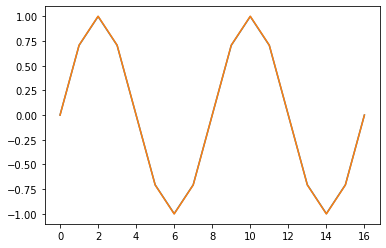

In [11]:
x_m=np.empty(len(xi1))
det=np.empty(len(xi1))
for idx in range(len(xi1)):
    i1=idx
    x_m[idx]= mapping.f(xi1[i1],xi2,xi3, *args_map, 1)
    det[idx] = mapping.df_inv(xi1, xi2, xi3, *args_map, 1*10+1)
fig = plt.figure()
rho_0_plot=eva.FEM_field_1d(coeffs, 1, xi1, T, deg, bc)*0.5
plt.plot(rho_0_plot)
plt.plot(rho_ini_phys(x_m))
np.amax(np.abs(rho_ini_phys(x_m)-rho_0_plot))

In [15]:
def rhov(xi1):
    global coeffs
    v=vx*df_inv
    rx=eva.FEM_field_1d(coeffs, 1, np.array([xi1]), T, deg, bc)
    return v*rx

In [169]:
[detdf,df,L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,obj,
coeffs,Int_mat_inv,der,Eva_mat]=ini_par(Nel=16,deg=3)
coeffs = obj.PI_1(func)
dt=0.001
L1_ERROR=[]
for it in range(10000):
    rhv=obj.PI_0(rhov)
    rho_t=-der.dot(rhv)
    coeffs=np.copy(coeffs+dt*rho_t)
    rho_0_plot=eva.FEM_field_1d(coeffs, 1, xi1, T, deg, bc)*df_inv
    rho_ex_1=density_analytical(dt,it+1)
    l1_error=np.sum(np.abs(rho_ex_1-rho_0_plot))
    L1_ERROR.append(l1_error)

In [153]:
[detdf,df,L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,obj,
coeffs,Int_mat_inv,der,Eva_mat]=ini_par(Nel=16,deg=3)
def RK4():
    global coeffs
    global dt
    rho_it=np.copy(coeffs)
    rhv=obj.PI_0(rhov)
    k1=-der.dot(rhv)
    coeffs=np.copy(rho_it+1/2*k1*dt)
    rhv=obj.PI_0(rhov)
    k2=-der.dot(rhv)
    coeffs=np.copy(rho_it+1/2*k2*dt)
    rhv=obj.PI_0(rhov)
    k3=-der.dot(rhv)
    coeffs=np.copy(rho_it+k3*dt)
    rhv=obj.PI_0(rhov)
    k4=-der.dot(rhv)
    coeffs=rho_it+dt*1/6*(k1+2*k2+2*k3+k4)
    return coeffs
#rho_coeff=RK4()
coeffs = obj.PI_1(func)
dt=0.001
L1_ERROR=[]
stability=[]
for it in range(1000):
    rhv=obj.PI_0(rhov)
    rho_t=-der.dot(rhv)
    coeffs=RK4()
    rho_0_plot=eva.FEM_field_1d(coeffs, 1, xi1, T, deg, bc)*df_inv
    rho_ex_1=density_analytical(dt,it+1)
    l1_error=np.sum(np.abs(rho_ex_1-rho_0_plot))
    L1_ERROR.append(l1_error)

/Users/juanesteban/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/juanesteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/Users/juanesteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add


<IPython.core.display.Javascript object>


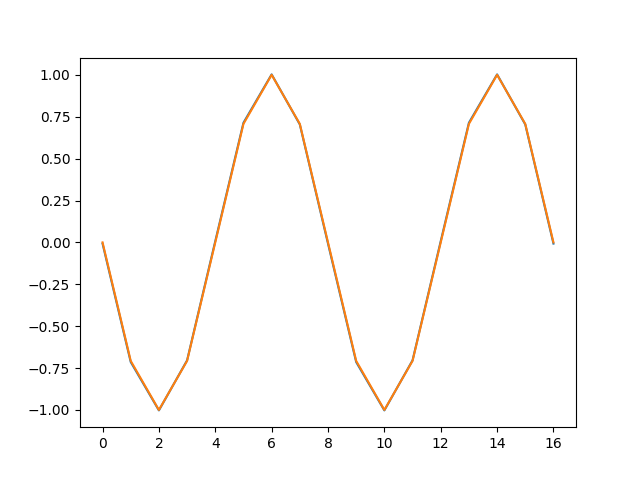

In [167]:
fig = plt.figure()
rho_0_plot=eva.FEM_field_1d(coeffs, 1, xi1, T, deg, bc)*df_inv
plt.plot(rho_0_plot)
plt.plot(rho_ex_1)
#plt.plot(density_analytical(dt,1))

<IPython.core.display.Javascript object>


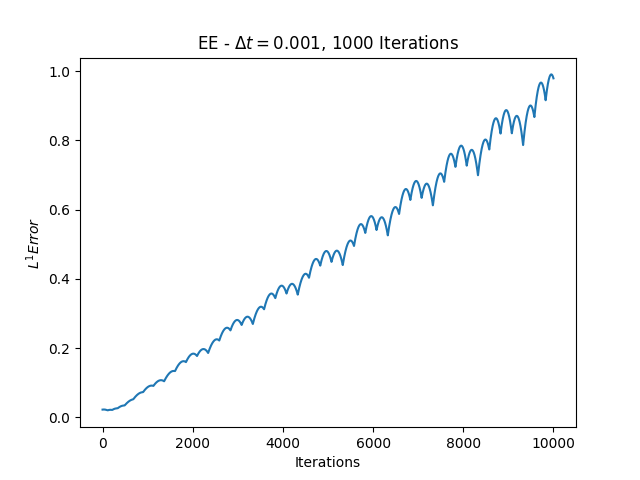

Text(0, 0.5, '$L^1 Error$')

In [170]:
%matplotlib notebook
fig = plt.figure()
plt.plot(L1_ERROR)
plt.title('EE - $\Delta t=$'+str(dt)+', 1000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('$L^1 Error$')

#### Stability Analysis for RK4

In [43]:
Rl=np.linspace(0,0,100)
il=np.linspace(-4,4,100)
stx=[]
STx=[]
sty=[]
STy=[]
for i in range(len(Rlamb)):
    for j in range(len(ilamb)):
        z=complex(Rl[i],il[j])
        qhl=1+z+1/2*z**2+1/6*z**3+1/24*z**4
        d=np.sqrt((qhl.conjugate()*qhl).real)
        if d<1:
            stx.append(Rl[i])
            sty.append(il[j])
    STx.append(stx)
    STy.append(sty)

In [102]:
import scipy
from scipy import optimize
def ff(x):
    z=complex(0,x)
    qh=1+z+1/2*z**2+1/6*z**3+1/24*z**4
    return np.sqrt((qh.conjugate()*qh).real)-1
scipy.optimize.fsolve(ff,3)

array([2.82842712])

In [156]:
Rl=np.linspace(-4,4,100)
il=np.linspace(-4,4,100)
stx=[]
STx=[]
sty=[]
STy=[]
for i in range(len(Rlamb)):
    for j in range(len(ilamb)):
        d=np.sqrt((1+Rl[i])**2+il[j]**2) 
        if d<1:
            stx.append(Rl[i])
            sty.append(il[j])
    STx.append(stx)
    STy.append(sty)

<IPython.core.display.Javascript object>


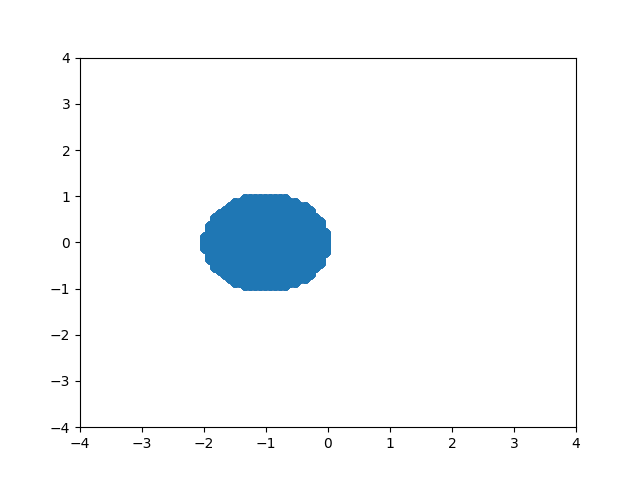

(-4, 4)

In [157]:
plt.figure()
plt.scatter(np.array(STx).flatten(),np.array(STy).flatten())
plt.plot()
plt.xlim(-4,4)
plt.ylim(-4,4)

##### $(I+v \Delta t DF^{-1} DI^{-1}_{k}\mathbb{C})\rho^{n+1}=\rho^n$

#### ##### $\rho^{n+1}=\rho^n-v \Delta t DF^{-1} DI^{-1}_{k}\mathbb{C}\rho^n$

In [27]:
def rhov(xi1):
    global coeffs
    v=vx*df_inv
    rx=eva.FEM_field_1d(coeffs, 1, np.array([xi1]), T, deg, bc)
    return v*rx

In [35]:
from scipy.sparse.linalg import splu
p=3
[detdf,df,L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,obj,
coeffs,Int_mat_inv,der,Eva_mat]=ini_par(Nel=100,deg=p)
dt=0.0001
L1_ERROR=[]
I=np.identity(len(Eva_mat))
for it in range(1):
    F_inv=np.linalg.inv(I+vx*df_inv*dt*der.dot(Int_mat_inv.dot(Eva_mat)))
    coeffs=np.copy(np.array(F_inv.dot(coeffs)))[0] #splu(sparse.csc_matrix(I-vx*df_inv*dt*der.dot(Int_mat_inv.dot(Eva_mat)))).solve(coeffs)
    rho_1_plot=eva.FEM_field_1d(coeffs, 1, xi1, T, p, bc)*df_inv
    rho_ex_1=density_analytical(dt,it+1)
    l1_error=np.sum(np.abs(rho_ex_1-rho_1_plot))
    L1_ERROR.append(l1_error)

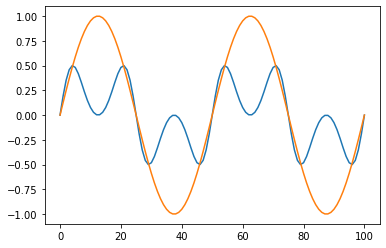

In [36]:
fig = plt.figure()
plt.plot(rho_1_plot)
plt.plot(rho_ex_1)

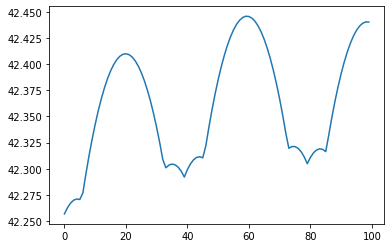

In [30]:
fig = plt.figure()
plt.plot(L1_ERROR)

#### Implicit Runge Kutta

In [ ]:
p=10
[detdf,df,L,deg,bc,Nel,Nq,dt,args_map,fun,el_b,xi1,xi2,xi3,df_inv,v,T,obj,
coeffs,Int_mat_inv,der,Eva_mat]=ini_par(Nel=500,deg=p)
dt=0.001
L1_ERROR=[]
I=np.identity(len(Eva_mat))
for it in range(1000):
    A=-vx*df_inv*dt*der.dot(Int_mat_inv.dot(Eva_mat))
    F_inv=np.linalg.inv(I-(A+1/2*A**2+1/6*A**3+1/24*A**4))
    coeffs=np.copy(np.array(F_inv.dot(coeffs)))[0] #splu(sparse.csc_matrix(I-vx*df_inv*dt*der.dot(Int_mat_inv.dot(Eva_mat)))).solve(coeffs)
    rho_1_plot=eva.FEM_field_1d(coeffs, 1, xi1, T, p, bc)*df_inv
    rho_ex_1=density_analytical(dt,it+1)
    l1_error=np.sum(np.abs(rho_ex_1-rho_1_plot))
    L1_ERROR.append(l1_error)

In [ ]:
fig = plt.figure()
plt.plot(rho_1_plot)
plt.plot(rho_ex_1)

In [ ]:
fig = plt.figure()
plt.plot(L1_ERROR)